In [37]:
from langgraph.graph import StateGraph ,START,END
from typing import TypedDict
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

In [38]:
load_dotenv()

True

In [39]:
from typing import Annotated
import operator

In [40]:
class essayState(TypedDict):
    essay : str
    clarityFeedback : str
    depthFeedback : str
    languageFeedback : str
    points : Annotated[list[int],operator.add]
    finalMarks: float
    finalEvaluation: str

In [41]:
from pydantic import BaseModel, Field

In [42]:
class reponseSchema(BaseModel):
    evaluation : str =Field(description='Detailed feedbackfor the essay')
    points: int = Field(description="Score out of 10",ge=0,le=10)

In [43]:
model =ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [44]:
structuredModel= model.with_structured_output(reponseSchema)

In [45]:
def clarityEval(state :essayState):
    prompt= f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    reponse = structuredModel.invoke(prompt)
    return {
        'clarityFeedback': reponse.evaluation,
        'points' : [reponse.points]
    }

In [47]:
def languageEval(state :essayState):
    prompt= f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    reponse = structuredModel.invoke(prompt)
    return {
        'languageFeedback': reponse.evaluation,
        'points' : [reponse.points]
    }

In [48]:
def depthEval(state :essayState):
    prompt= f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    reponse = structuredModel.invoke(prompt)
    return {
        'depthFeedback': reponse.evaluation,
        'points' : [reponse.points]
    }

In [49]:
def finalEval(state : essayState):
    prompt=f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["languageFeedback"]} \n depth of analysis feedback - {state["depthFeedback"]} \n clarity of thought feedback - {state["clarityFeedback"]}'
    reponse = model.invoke(prompt)
    avgScore=sum(state["points"])/len(state["points"])
    return { 
        'finalEvaluation':reponse,
        'finalMarks':avgScore
    }

In [50]:
graph = StateGraph(essayState)

In [51]:
graph.add_node('languageEval',languageEval)
graph.add_node('depthEval',depthEval)
graph.add_node('clarityEval',clarityEval)
graph.add_node('finalEval',finalEval)

graph.add_edge(START, 'languageEval')
graph.add_edge(START, 'depthEval')
graph.add_edge(START, 'clarityEval')

graph.add_edge('languageEval','finalEval')
graph.add_edge('depthEval', 'finalEval')
graph.add_edge('clarityEval', 'finalEval')
graph.add_edge('finalEval',END)


workflow=graph.compile()


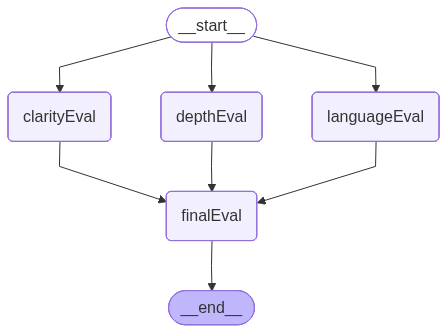

In [52]:
workflow

In [53]:
essay2 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""

In [54]:
initial_state ={
    'essay':essay2
}
final_state=workflow.invoke(initial_state)

In [55]:
final_state

{'essay': 'India and AI Time\n\nNow world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.\n\nIndia have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.\n\nIn farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.\n\nBut problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.\n\nOne more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.\n\n